<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/400final_1_training_samples_W207_Breast_Cancer_IDC_Prediction_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
**Heesuk Jang**
 

#Predicting IDC (Invasive Ductal Carcinoma) with Breast Histopathology Images using a CNN

- Need to perform data augmentations on train/test/validation data sets


In [4]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


# CNN - ML pipeline

  1) EDA and Image Visualization<br>
  2) Randomly sample from training/test/validation = 400/ 200/ 200 (50%/ 25%/ 25%)<br>
  3) Image Transformations<br>
> Image resize<br>
> Image normalization to [0, 1]<br>
  
  4) [Image Augmentations](https://iq.opengenus.org/data-augmentation/)<br>
> Adjust brightness<br>
> Adjust contrast<br>
> Flip left and right<br>

 5) CNN Model using Tensorflow Keras API<br>
> Build model<br>
> Compile model<br>
> Fit model<br>

 6) Evaluate the Model<br>
 : Determine how good our trained model applies in predicting unseen (test) data.
> model.**evaluate**<br>
> model.**predict**<br>
> Evaluation Metrics:  True Labels VS. Predicted Labels<br>

 7) Hyper Parameter Tuning<br>
> Optimizer<br>
> Learning Rate<br>
> Dropout ratio<br>
> Number of Epochs<br>
> Contrast Factor<br>
> Delta<br>









In [ ]:
%pwd

'/content'

## Unzip the Dataset zip from Google Drive

In [5]:
!unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

Archive:  gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip
   creating: Dataset/
   creating: Dataset/Validate/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/Test/
   creating: Dataset/Train/
  inflating: Dataset/Validate/.DS_Store  
  inflating: __MACOSX/Dataset/Validate/._.DS_Store  
   creating: Dataset/Validate/0/
   creating: Dataset/Validate/1/
  inflating: Dataset/Test/.DS_Store  
  inflating: __MACOSX/Dataset/Test/._.DS_Store  
   creating: Dataset/Test/0/
   creating: Dataset/Test/1/
  inflating: Dataset/Train/.DS_Store  
  inflating: __MACOSX/Dataset/Train/._.DS_Store  
   creating: Dataset/Train/0/
   creating: Dataset/Train/1/
  inflating: Dataset/Validate/0/12867_idx5_x651_y1801_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._12867_idx5_x651_y1801_class0.png  
  inflating: Dataset/Validate/0/16165_idx5_x3001_y1551_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._16165_idx5_x3001_y1551_class0.png  
  inflating

## Read the first 200 images of each class from training/test/validation from each class 
Correct for data imbalance by sampling equal size of images from each class
- **Class 0 (Non-IDC)**
- **Class 1 (IDC)**

### Training/ Test/ Validation = 400/ 200/ 200

In [6]:
def read_images(binary_class, folder):
  current_working_dir = os.getcwd()
  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path) 
  # if folder == 'Dataset/Train/':
  #   image_files_wo_path, image_files_w_path = image_files_wo_path[:200], image_files_w_path[:200]
  return image_files_wo_path, image_files_w_path    

In [7]:
# ======================================================================== #
# ===================== Read Training Images ============================= #
# ======================================================================== #

train_class_1_wo_path, train_class_1_w_path = read_images('1', 'Dataset/Train/')
train_class_0_wo_path, train_class_0_w_path = read_images('0', 'Dataset/Train/')
train_full_wo_path = train_class_1_wo_path + train_class_0_wo_path
train_full_w_path = train_class_1_w_path + train_class_0_w_path

print(f'Size of Train Class 1 = {len(train_class_1_wo_path)} | {type(train_class_1_wo_path)}\nSample Images in Train Class 1:\n {train_class_1_wo_path[:2]}')
print(f'\nxSize of Train Class 0 = {len(train_class_0_wo_path)} | {type(train_class_0_wo_path)}\nSample Images in Train Class 0:\n {train_class_0_wo_path[:2]}')
print('\nTrain class_1 and class_0 combined:\n',train_full_wo_path[0], ',', train_full_wo_path[-1])
print('\nTrain class_1 with full path:\n',train_class_1_w_path[:2])

Size of Train Class 1 = 400 | <class 'list'>
Sample Images in Train Class 1:
 ['16568_idx5_x2001_y901_class1.png', '14190_idx5_x2701_y1551_class1.png']

xSize of Train Class 0 = 400 | <class 'list'>
Sample Images in Train Class 0:
 ['9265_idx5_x3101_y1951_class0.png', '14211_idx5_x1801_y1701_class0.png']

Train class_1 and class_0 combined:
 16568_idx5_x2001_y901_class1.png , 12954_idx5_x1651_y2951_class0.png

Train class_1 with full path:
 ['/content/Dataset/Train/1/16568_idx5_x2001_y901_class1.png', '/content/Dataset/Train/1/14190_idx5_x2701_y1551_class1.png']


In [8]:
# ======================================================================== #
# ===================== Read Test Images ================================= #
# ======================================================================== #

test_class_1_wo_path, test_class_1_w_path = read_images('1', 'Dataset/Test/')
test_class_0_wo_path, test_class_0_w_path = read_images('0', 'Dataset/Test/')
test_full_wo_path = test_class_1_wo_path + test_class_0_wo_path
test_full_w_path = test_class_1_w_path + test_class_0_w_path

print(f'Size of Test Class 1 = {len(test_class_1_wo_path)} | {type(test_class_1_wo_path)}\nSample Images in Test Class 1:\n {test_class_1_wo_path[:2]}')
print(f'\nSize of Test Class 0 = {len(test_class_0_wo_path)} | {type(test_class_0_wo_path)}\nSample Images in Test Class 0:\n {test_class_0_wo_path[:2]}')
print('\nTest class_1 and class_0 combined:\n',test_full_wo_path[0], ',', test_full_wo_path[-1])
print('\nTest class_1 with full path:\n',test_class_1_wo_path[:2])

Size of Test Class 1 = 100 | <class 'list'>
Sample Images in Test Class 1:
 ['9346_idx5_x1151_y1751_class1.png', '9176_idx5_x1401_y1451_class1.png']

Size of Test Class 0 = 100 | <class 'list'>
Sample Images in Test Class 0:
 ['9029_idx5_x51_y801_class0.png', '9081_idx5_x2051_y651_class0.png']

Test class_1 and class_0 combined:
 9346_idx5_x1151_y1751_class1.png , 10305_idx5_x1501_y1101_class0.png

Test class_1 with full path:
 ['9346_idx5_x1151_y1751_class1.png', '9176_idx5_x1401_y1451_class1.png']


In [9]:
# ======================================================================== #
# ===================== Read Validation Images =========================== #
# ======================================================================== #

val_class_1_wo_path, val_class_1_w_path = read_images('1', 'Dataset/Validate/')
val_class_0_wo_path, val_class_0_w_path = read_images('0', 'Dataset/Validate/')
val_full_wo_path = val_class_1_wo_path + val_class_0_wo_path
val_full_w_path = val_class_1_w_path + val_class_0_w_path

print(f'Size of Validation Class 1 = {len(val_class_1_wo_path)} | {type(val_class_1_wo_path)}\nSample Images in Validation Class 1:\n {val_class_1_wo_path[:2]}')
print(f'\nSize of Validation Class 0 = {len(val_class_0_wo_path)} | {type(val_class_0_wo_path)}\nSample Images in Validation Class 0:\n {val_class_0_wo_path[:2]}')
print('\nValidation class_1 and class_0 combined:\n',val_full_wo_path[0], ',', val_full_wo_path[-1])
print('\nValidation class_1 with full path:\n',val_class_1_wo_path[:2])

Size of Validation Class 1 = 100 | <class 'list'>
Sample Images in Validation Class 1:
 ['9081_idx5_x2501_y1251_class1.png', '13462_idx5_x1551_y1251_class1.png']

Size of Validation Class 0 = 100 | <class 'list'>
Sample Images in Validation Class 0:
 ['10300_idx5_x1401_y2051_class0.png', '16085_idx5_x2001_y2501_class0.png']

Validation class_1 and class_0 combined:
 9081_idx5_x2501_y1251_class1.png , 8984_idx5_x3001_y251_class0.png

Validation class_1 with full path:
 ['9081_idx5_x2501_y1251_class1.png', '13462_idx5_x1551_y1251_class1.png']


## Check the number of train images in each class


In [10]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count (Balanced) = ', class_1_size + class_0_size)
  return df_perc

check_class_size(train_class_1_wo_path, train_class_0_wo_path)

Total Count (Balanced) =  800


,class,class_count,class_percent(%)
0,Class 1 (Malignant),400,50.0
1,Class 0 (Benign),400,50.0


## Create dataframes of training/test/validation for each class

In [11]:
def create_class_df(class_1_w_path, class_0_w_path): 
  image_list_w_path = [x for x in class_1_w_path]
  image_list_w_path.extend([x for x in class_0_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(class_1_w_path), ['Non_IDC']*len(class_0_w_path)]), columns=['class_str'])
  df_idc['class'] = np.where(df_idc.class_str == 'IDC', 1, 0)
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

In [12]:
# ======================================================================== #
# ===================== Create Train DF ================================== #
# ======================================================================== #
df_train_full = create_class_df(train_class_1_w_path, train_class_0_w_path)
training_sample_size = df_train_full.shape[0]
df_train_full

Shape:  (800, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Train/1/16568_idx5_x2001_y901...
1,IDC,1,/content/Dataset/Train/1/14190_idx5_x2701_y155...
2,IDC,1,/content/Dataset/Train/1/13459_idx5_x1051_y551...
3,IDC,1,/content/Dataset/Train/1/12949_idx5_x1651_y951...
4,IDC,1,/content/Dataset/Train/1/13591_idx5_x2301_y185...
...,...,...,...
795,Non_IDC,0,/content/Dataset/Train/0/13459_idx5_x1301_y751...
796,Non_IDC,0,/content/Dataset/Train/0/16550_idx5_x2101_y501...
797,Non_IDC,0,/content/Dataset/Train/0/10259_idx5_x1551_y110...
798,Non_IDC,0,/content/Dataset/Train/0/9125_idx5_x1551_y1301...


In [13]:
# ======================================================================== #
# ===================== Create Test DF ================================== #
# ======================================================================== #
df_test_full = create_class_df(test_class_1_w_path, test_class_0_w_path)
df_test_full

Shape:  (200, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Test/1/9346_idx5_x1151_y1751_...
1,IDC,1,/content/Dataset/Test/1/9176_idx5_x1401_y1451_...
2,IDC,1,/content/Dataset/Test/1/10260_idx5_x1101_y451_...
3,IDC,1,/content/Dataset/Test/1/14154_idx5_x1501_y651_...
4,IDC,1,/content/Dataset/Test/1/12933_idx5_x1051_y801_...
...,...,...,...
195,Non_IDC,0,/content/Dataset/Test/0/12751_idx5_x1451_y601_...
196,Non_IDC,0,/content/Dataset/Test/0/16551_idx5_x1751_y2301...
197,Non_IDC,0,/content/Dataset/Test/0/12949_idx5_x1851_y1651...
198,Non_IDC,0,/content/Dataset/Test/0/9259_idx5_x2351_y1501_...


In [14]:
# ======================================================================== #
# ===================== Create Validation DF ============================= #
# ======================================================================== #
df_val_full = create_class_df(val_class_1_w_path, val_class_0_w_path)
df_val_full

Shape:  (200, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Validate/1/9081_idx5_x2501_y1...
1,IDC,1,/content/Dataset/Validate/1/13462_idx5_x1551_y...
2,IDC,1,/content/Dataset/Validate/1/12879_idx5_x1001_y...
3,IDC,1,/content/Dataset/Validate/1/12947_idx5_x1451_y...
4,IDC,1,/content/Dataset/Validate/1/14191_idx5_x1801_y...
...,...,...,...
195,Non_IDC,0,/content/Dataset/Validate/0/8959_idx5_x1251_y4...
196,Non_IDC,0,/content/Dataset/Validate/0/12878_idx5_x3151_y...
197,Non_IDC,0,/content/Dataset/Validate/0/12870_idx5_x501_y2...
198,Non_IDC,0,/content/Dataset/Validate/0/9324_idx5_x2651_y1...


## Image distribution in the training data set

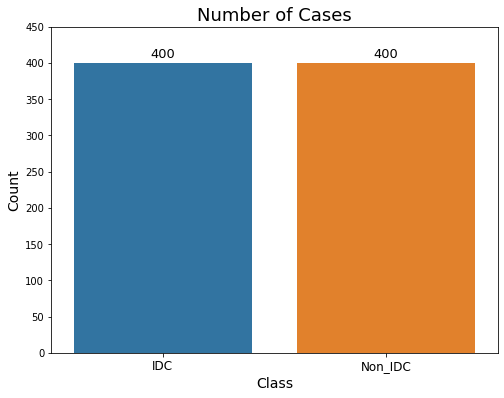

In [15]:
plt.figure(figsize=(8,6))
ax = sns.countplot(df_train_full['class_str'], data=df_train_full)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.title('Number of Cases', fontsize=18)
plt.ylim(0,450)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2., 
                p.get_height()), ha='center', va='center', size=15, xytext=(0,9),
               textcoords = 'offset points', fontsize=13)

## Display 6 train images for each class
: 512 (width) by 512 (height) array of pixel values per image

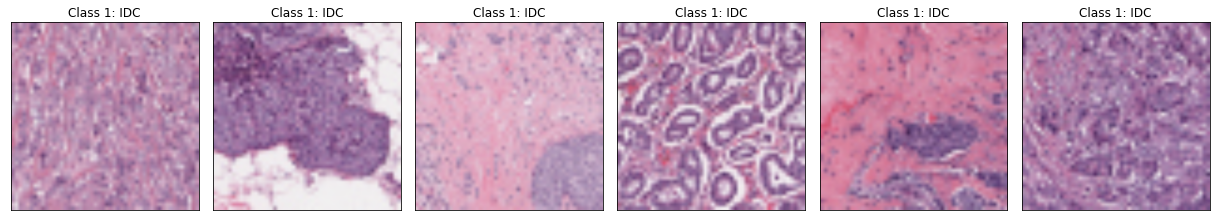

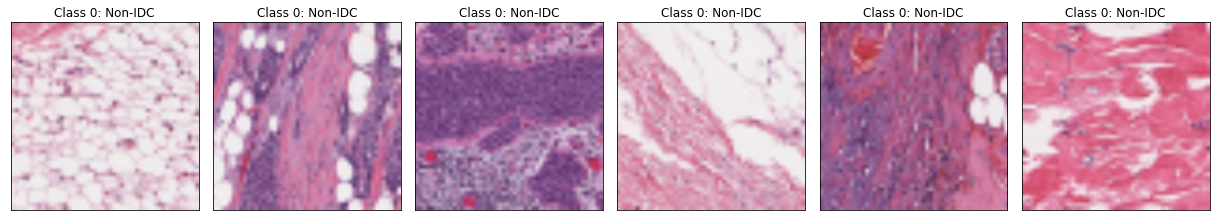

In [16]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  # images = []
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (512,512))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_class_1_w_path, 'Class 1: IDC')
display_images(train_class_0_w_path, 'Class 0: Non-IDC')

## Store actual color images as a vector


In [17]:
# from skimage import color
def store_actual_images_to_grayscale(class_1_w_path, class_0_w_path):
  # read and store actual images (not the image paths) into the respective variable as a single vector then pass these to the model below
  image_pixels_class1 = [io.imread(img) for img in class_1_w_path]
  image_pixels_class0 = [io.imread(img) for img in class_0_w_path]
  full_image_pixels = np.asarray(image_pixels_class1 + image_pixels_class1)   # => (#samples, width, height)
  return image_pixels_class1, image_pixels_class0, full_image_pixels

In [18]:
# ======================================================================== #
# ===================== Store Train Images =============================== #
# ======================================================================== #
train_img_class1, train_img_class0, train_full_img = store_actual_images_to_grayscale(train_class_1_w_path, train_class_0_w_path)

print('Shape of each train image: ', train_img_class1[0].shape)
print('\nTotal number of images = ', len(train_full_img))
print('Number of class 1 images = ', len(train_img_class1))
print('Number of class 0 images = ', len(train_img_class0))
print('train_full_img = ', train_full_img.shape)

Shape of each train image:  (50, 50, 3)

Total number of images =  800
Number of class 1 images =  400
Number of class 0 images =  400
train_full_img =  (800, 50, 50, 3)


In [19]:
# ======================================================================== #
# ===================== Store Test Images ================================ #
# ======================================================================== #
test_img_class1, test_img_class0, test_full_img = store_actual_images_to_grayscale(test_class_1_w_path, test_class_0_w_path)

print('Shape of each test image: ', test_img_class1[0].shape)
print('\nTotal number of images = ', len(test_full_img))
print('Number of class 1 images = ', len(test_img_class1))
print('Number of class 0 images = ', len(test_img_class0))
print('test_full_img = ', test_full_img.shape)

Shape of each test image:  (50, 50, 3)

Total number of images =  200
Number of class 1 images =  100
Number of class 0 images =  100
test_full_img =  (200, 50, 50, 3)


In [20]:
# ======================================================================== #
# ===================== Store Validation Images ========================== #
# ======================================================================== #
val_img_class1, val_img_class0, val_full_img = store_actual_images_to_grayscale(val_class_1_w_path, val_class_0_w_path)

print('Shape of each validataion image: ', val_img_class1[0].shape)
print('\nTotal number of images = ', len(val_full_img))
print('Number of class 1 images = ', len(val_img_class1))
print('Number of class 0 images = ', len(val_img_class0))
print('val_full_img = ', val_full_img.shape)

Shape of each validataion image:  (50, 50, 3)

Total number of images =  200
Number of class 1 images =  100
Number of class 0 images =  100
val_full_img =  (200, 50, 50, 3)


## Image augmentation techniques on a training image

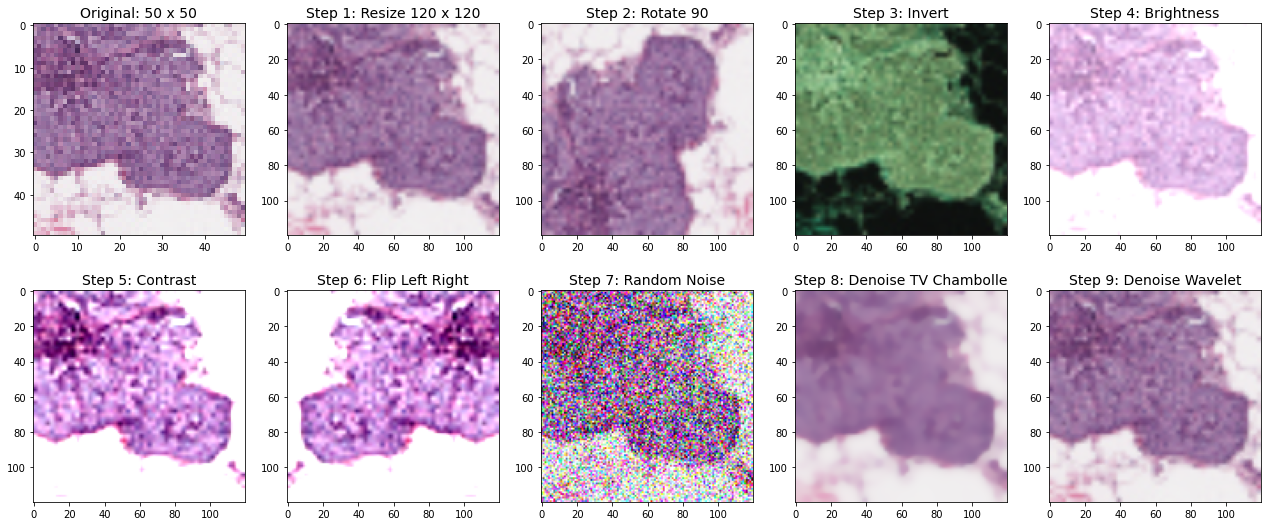

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import util
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma

fig = plt.figure(figsize=(22,9))
# original image
original = io.imread(train_class_1_w_path[1])

# resized image
resized_img = cv.resize(train_img_class1[1], (120,120))

# pull an original image as is
ax = fig.add_subplot(2,5,1)
ax.imshow(original)
# ax.axis('off')
ax.set_title('Original: 50 x 50', size=14)

# resize an original image to 120 x 120
ax = fig.add_subplot(2,5,2)
ax.imshow(resized_img)                         
# ax.axis('off')
ax.set_title('Step 1: Resize 120 x 120', size=14)

# rotate an original image 90 degrees
ax = fig.add_subplot(2,5,3)
rot90_img = tf.image.rot90(resized_img, k=1)
ax.imshow(rot90_img)
# ax.axis('off')
ax.set_title('Step 2: Rotate 90', size=14)

# invert the resized image
ax = fig.add_subplot(2,5,4)
inverted_img = util.invert(resized_img)
plt.imshow(inverted_img);
# ax.axis('off')
ax.set_title('Step 3: Invert', size=14)

# adjust brightness of the resized image
ax = fig.add_subplot(2,5,5)
bright_img = tf.image.adjust_brightness(resized_img, 0.3)
plt.imshow(bright_img);
# ax.axis('off')
ax.set_title('Step 4: Brightness', size=14)

# adjust contrast of the brightened image
ax = fig.add_subplot(2,5,6)
contrast_img = tf.image.adjust_contrast(bright_img, contrast_factor=3)
plt.imshow(contrast_img);
# ax.axis('off')
ax.set_title('Step 5: Contrast', size=14)

# flip left right of the contrasted image
ax = fig.add_subplot(2,5,7)
flipped_img = tf.image.flip_left_right(contrast_img)
plt.imshow(flipped_img);
# ax.axis('off')
ax.set_title('Step 6: Flip Left Right', size=14)

# random noise: function to add random noise of various types to a floating-point image
ax = fig.add_subplot(2,5,8)
sigma = 0.355
noisy_img = random_noise(resized_img, var=sigma**2)
plt.imshow(noisy_img);
# ax.axis('off')
ax.set_title('Step 7: Random Noise', size=14)

# denoise_tv_chambolle: perform total-variation denoising on n-dimentional images
ax = fig.add_subplot(2,5,9)
dchambolle_img = denoise_tv_chambolle(resized_img, weight=0.1, multichannel=True)
plt.imshow(dchambolle_img);
# ax.axis('off')
ax.set_title('Step 8: Denoise TV Chambolle', size=14)

# denoise_wavelet:  perform wavelet denoising on an image
ax = fig.add_subplot(2,5,10)
dwavelet_img = denoise_wavelet(resized_img, multichannel=True)
plt.imshow(dwavelet_img);
# ax.axis('off')
ax.set_title('Step 9: Denoise Wavelet', size=14);

## Specify image data (X) and labels (y)

In [22]:
def define_X_and_y(data_pixels, df_data):
  X = data_pixels
  y = np.array(df_data['class']).flatten()   # no need to flatten here but maybe later on before I feed this to the model 
  return X, y

In [23]:
X_train, y_train = define_X_and_y(train_full_img, df_train_full)
X_test, y_test = define_X_and_y(test_full_img, df_test_full)
X_val, y_val = define_X_and_y(val_full_img, df_val_full)

print('X_train: ', X_train.shape, type(X_train))
print('X_test: ',X_test.shape, type(X_test))
print('X_val: ',X_val.shape, type(X_val))

X_train:  (800, 50, 50, 3) <class 'numpy.ndarray'>
X_test:  (200, 50, 50, 3) <class 'numpy.ndarray'>
X_val:  (200, 50, 50, 3) <class 'numpy.ndarray'>


## Randomize images (X) and labels (y) 
Using index shuffling

In [24]:
# print(X_train[0],'\n')
def shuffle_X_and_y(X, y):
  tf.random.set_seed(1234)
  np.random.seed(1234)
  shuffle = np.random.permutation(np.arange(X_train.shape[0]))      # randomize 
  return X_train[shuffle], y_train[shuffle]

In [25]:
X_train, y_train = shuffle_X_and_y(X_train, y_train)
X_test, y_test = shuffle_X_and_y(X_test, y_test)
X_val, y_val = shuffle_X_and_y(X_val, y_val)

print('y_val_shuffled:\n', y_val)
print('\ny_test_shuffled:\n', y_test)
print('\ny_train: total number of labels = ', len(y_train), type(y_train) ,'\n', y_train[:5], y_train[-5:])
print('\nX_train: total number of images = ', len(X_train), type(X_train), '\n', X_train[0])

y_val_shuffled:
 [0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0
 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0
 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1
 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1
 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1
 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1
 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0
 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0
 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1
 1 0 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1
 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1
 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0
 0 1 0 1

## Resize images from (50, 50) to (120, 120) on X

In [26]:
image_size = (224,224)
X_train = tf.image.resize(X_train, size=image_size)
X_test = tf.image.resize(X_test, size=image_size)
X_val = tf.image.resize(X_val, size=image_size)
print(type(X_train), X_train.shape)
print('\nX_train[0]:\n',X_train[0])


<class 'tensorflow.python.framework.ops.EagerTensor'> (800, 224, 224, 3)

X_train[0]:
 tf.Tensor(
[[[149.        72.       117.      ]
  [149.        72.       117.      ]
  [149.75447   72.34821  117.52232 ]
  ...
  [147.30356   81.187485 131.24551 ]
  [148.        82.       132.      ]
  [148.        82.       132.      ]]

 [[149.        72.       117.      ]
  [149.        72.       117.      ]
  [149.75447   72.34821  117.52232 ]
  ...
  [147.30356   81.187485 131.24551 ]
  [148.        82.       132.      ]
  [148.        82.       132.      ]]

 [[147.66518   71.70982  117.17411 ]
  [147.66518   71.70982  117.17411 ]
  [148.45332   72.12877  117.73348 ]
  ...
  [143.03845   78.08983  128.19579 ]
  [143.64732   78.80804  128.86607 ]
  [143.64732   78.80804  128.86607 ]]

 ...

 [[172.07141  108.839264 148.18748 ]
  [172.07141  108.839264 148.18748 ]
  [170.49693  106.60204  146.0495  ]
  ...
  [136.75623   57.089226 105.64514 ]
  [135.56699   56.52233  105.23215 ]
  [135.56699   

## Convert to gray scale and normalize images
Rescale images to [0,1]

In [27]:
X_train = tf.image.rgb_to_grayscale(X_train)/255.0
X_test = tf.image.rgb_to_grayscale(X_test)/255.0
X_val = tf.image.rgb_to_grayscale(X_val)/255.0
print(X_train.shape)
# print(X_train[0])

(800, 224, 224, 1)


# Image Augmentation on Training Data
- Adjust brightness
- Adjust contrast
- Flip left and right
- Rotate 90 degrees

In [28]:
brightness_delta = 0.3
contrast_factor = 3
rot_degree = 1               # rotate mapping => key:val = angle:k = {90:1, 180:2, 270:3}

# add a set of augmented images to X_train_norm rather than overwrite the existing ones
X_train_bright = tf.image.adjust_brightness(X_train, delta=brightness_delta)
X_train_contrast = tf.image.adjust_contrast(X_train, contrast_factor=contrast_factor)
X_train_flip = tf.image.random_flip_left_right(X_train)
X_train_rot90 = tf.image.rot90(X_train, k=rot_degree)            
# X_train_invert = util.invert(X_train)
# X_train_noise = random_noise(X_train, var=0.355**2)   # sigma = 0.355
# dchambolle_img = denoise_tv_chambolle(X_train, weight=0.1, multichannel=True)
# X_train_dwavelet = denoise_wavelet(X_train, multichannel=True)

## Merge original training images with the augmented images

In [29]:
# concatenate X_train_final with augmented X_train
X_train = tf.concat([X_train, 
                           X_train_bright, 
                           X_train_contrast, 
                           X_train_flip,
                           X_train_rot90], axis=0)
print('X_train with augmentation: ', X_train.shape)

# concatenate y_train (the label is preserved)
y_train = y_train
y_train_bright, y_train_contrast, y_train_flip, y_train_rot90 = y_train, y_train, y_train, y_train
y_train = tf.concat([y_train, 
                           y_train_bright, 
                           y_train_contrast, 
                           y_train_flip,
                           y_train_rot90], axis=0)
print('y_train_bright: ', y_train_bright.shape)
print('y_train with augmentation: ', y_train.shape)

X_train with augmentation:  (4000, 224, 224, 1)
y_train_bright:  (800,)
y_train with augmentation:  (4000,)


## Shuffle X_train and y_train
Shuffle two tensors in the same order

In [30]:
print(tf.shape(X_train))
shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
X_train = tf.gather(X_train, shuffle)
y_train = tf.gather(y_train, shuffle).numpy()  # also transforms y_train to numpy array

tf.Tensor([4000  224  224    1], shape=(4,), dtype=int32)


In [31]:
print(X_train[0][1][1])
print(y_train[:100])

tf.Tensor([0.4425604], shape=(1,), dtype=float32)
[0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0
 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1
 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0]


## Display the first 10 train and validation examples with the label of each example as the title

Print training data examples:


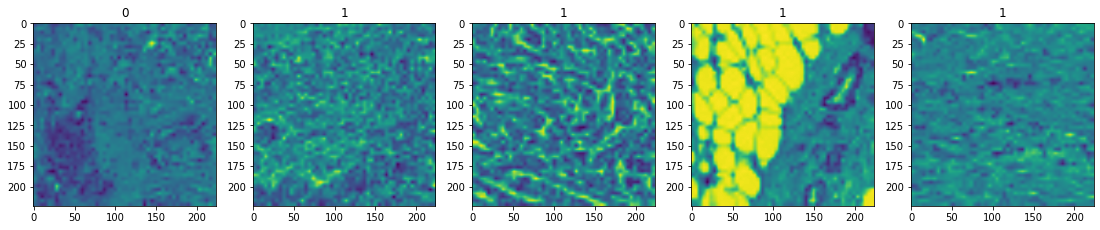

In [33]:
print('Print training data examples:')
nrows, ncols = 1,5 
f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


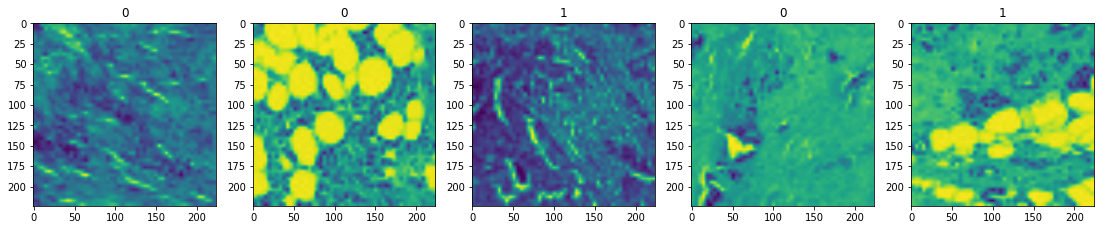

In [34]:
# print validation data
print('Print validation data examples:')
nrows, ncols = 1,5 
f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

In [35]:
# # print test data
# print('Print test data examples:')
# nrows, ncols = 1,5 
# f, axs = plt.subplots(nrows, ncols, figsize=(19,15))
# for i in range(ncols):
#     axs[i].imshow(array_to_img(X_test[i]))
#     axs[i].set(title=y_test[i])

## CNN Model using Tensorflow Keras API<br>
### 1) Build model<br>
  - The model receives input images of size **(150 x 150 x 1)**
  - The input data goes through a **flattening** layer
  - The flatten input goes through **three connected layers**, followed by a **dropout layer**
    - For the dropout layer, we set the probability of dropping input units during training to **0.3**

> We need a way to read and then feed to our CNN all those rescaled images from our dataframes and that is where the method flow_from_dataframe comes in.
  - **targt_size = (150,150):** can increase or decrease this according to your computational resources.
  - **batch_size:** defines the number of samples that we've propagated through the network, basically, number of images per batch that is fed into the CNN. This value typically ranges from 16 - 512. Large batch sizes require more computational power so we here have set this to 32.

### 2) Compile Model<br>
Initial param values:
- [activation](https://keras.io/api/layers/activations/) = relu
- optimizer = SGD
- learning_rate = 0.01

In [36]:
input_shape = (224,224,1)
filters_1 = 32
filters_2 = 64
# filters_3 = 64
kernel_size = (5,5)
pool_size = (2,2)
strides = (1, 1)
fully_connected_layer_units = 512
dropout_rate = 0.3

def build_model(activation='tanh',
                optimizer='SGD',
                learning_rate=0.01):
  
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Building the CNN
  model = Sequential()      # initialize the model using Sequential(), which indicates our network will be stacked with different layers

  # Define activation function
  if activation.lower() == 'leakyrelu':
    activation = tf.keras.layers.LeakyReLU(alpha=0.3)    # alpha = Float >= 0. Negative slope coefficient. Default to 0.3
  
  # Add the convolutional layers
  model.add(Conv2D(filters=filters_1, kernel_size=kernel_size, activation=activation, padding='same', input_shape=input_shape))                  # 1st convolutional layer
  model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 1st Pooling
  model.add(Conv2D(filters=filters_2, kernel_size=kernel_size, activation=activation, padding='same'))                                           # 2nd convolutional layer
  model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 2nd Pooling
  # model.add(Conv2D(filters=filters_3, kernel_size=kernel_size, activation=activation, padding='same'))                                           # 3rd convolutional layer
  # model.add(MaxPooling2D(pool_size=pool_size, strides=strides))                                                                                 # 3rd Pooling

  # Flatten the dataset to feed into a fully connected layer
  model.add(Flatten())    

  # Fully connected layer
  model.add(Dense(units=fully_connected_layer_units,                 # This can be adjusted (a hyper param)
                  activation=activation))                            # For the first layer: the number of units or neurons

  # Dropout layer
  model.add(Dropout(rate=dropout_rate))
  
  # Output layer
  model.add(Dense(
        units=1,                                 # binary output dimension (only one neuron)
        # use_bias=True,                           # Alternative: use_bias=False
        activation=None))                     # activation='sigmoid'

  if optimizer.lower() == 'adam':
    optimizer = Adam(learning_rate=learning_rate)
  elif optimizer.lower() == 'sgd':
    optimizer = SGD(learning_rate=learning_rate)   

  #  Compiling
  model.compile(loss='binary_crossentropy',             # for a binary classification
                optimizer=optimizer,                    # used to change the attributes of a neural network such as weights and learning rate to reduce the losses.
                metrics=['accuracy'])            
  print(f'CNN Model:\nActivation = {activation}\nOptimizer = {optimizer}\nlearning_rate = {learning_rate}\n')
  return model

###  A set of optimal param combinations:
(10/5) 400 training samples => act: **relu**, opt: **SGD**, lr = **0.001**

In [ ]:
learning_rate = 0.1
activation='relu'
optimizer='adam'

model = build_model(activation=activation,              # relu, leakyrelu, tanh, sigmoid
                optimizer=optimizer,                    # adam, [SGD]        
                learning_rate=learning_rate)        # 0.1, 0.01, 0.001
model.summary()

In [ ]:
# # Cornelia's code

  
# tf.keras.backend.clear_session()
# tf.random.set_seed(0)

# # first layer: input
# input1 = tf.keras.layers.Input(shape=(224, 224, 1), name='Input')

# # second layer: flatten (transforms the format of the images (to a 1D array of 224*224 = 50176 pixels)
# # this layer has no params or weights to learn, it only reformats data
# input2 = tf.keras.layers.Flatten(name='Flatten')(input1)
    
# # third layer: dense (i.e., the nodes are fully connected)
# # this layer has 12544 nodes (112 x 112 image), and it uses the activation function Rectified Linear Unit
# input3 = tf.keras.layers.Dense(units=12544, activation='relu', name='fc_1')(input2)
    
# # forth layer: dense (i.e., the nodes are fully connected)
# # this layer has 3136 nodes (56 x 56 image), and it uses the activation function Rectified Linear Unit
# input4 = tf.keras.layers.Dense(units=3136, activation='relu', name='fc_2')(input3)
    
# # fifth layer: dense (i.e., the nodes are fully connected)
# # this layer has 784 nodes (28 x 28), and it uses the activation function Rectified Linear Unit
# input5 = tf.keras.layers.Dense(units=784, activation='relu', name='fc_3')(input4)

# # sixth layer: dropout
# # makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
# # This helps with computation time (less parameters) and with overfitting.
# # each node in the third layer has a 0.3 probability of being dropped from the computation of the activations of the next layer. 
# input6 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input5)

# #the sixth (and last) layer, which is the output layer
# # this last layer sets the activation function to "None" in order to output the logits 
# # logits = natural logarithm of the odds ratio
# # note that passing activation = "sigmoid" will return class memembership probabilities but
# # in TensorFlow logits are prefered for numerical stability
# # set units=1 to get a single output unit (remember it's a binary classification problem)

# out = tf.keras.layers.Dense(units=1, activation=None, name='fc_4')(input6)

# # instantiate the model
# model = tf.keras.models.Model(inputs=input1, outputs=out)

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  
#             # ^ because our last layer does not apply sigmoid, by specifying from logits=True, the loss function applies the sigmoid function internally
#             # ^ it's more efficient than doing it manually
#             metrics=['accuracy']) # you can add other metrics here
# model.summary()

### 3) Fit Model

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(4000, 224, 224, 1)
(4000,)
(800, 224, 224, 1)
(800,)


In [ ]:
num_epochs = 10
batch_size = 8

print(f'Hyperparameters: \
      \n\ttraining_sample_size = {training_sample_size} \
      \n\tnum_epochs = {num_epochs} \
      \n\tbatch_size = {batch_size} \
      \n\timage_size = {image_size} \
      \n\tinput_shape = {input_shape} \
      \n\tfilters_1 = {filters_1} \
      \n\tfilters_2 = {filters_2} \
      \n\tfilters_3 = {filters_3} \
      \n\tkernel_size = {kernel_size} \
      \n\tpool_size = {pool_size} \
      \n\tstrides = {strides} \
      \n\tlearning_rate = {learning_rate} \
      \n\tactivation = {activation} \
      \n\toptimizer = {optimizer} \
      \n\nImage Agumentation Params: \
      \n\tbrightness_delta = {brightness_delta} \
      \n\tcontrast_factor = {contrast_factor} \
      \n\trot_degree = {rot_degree}\n')


tf.random.set_seed(1234)
np.random.seed(1234)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data = (X_val, y_val))

Hyperparameters:       
	training_sample_size = 800       
	num_epochs = 10       
	batch_size = 8       
	image_size = (224, 224)       
	input_shape = (224, 224, 1)       
	filters_1 = 16       
	filters_2 = 32       
	filters_3 = 64       
	kernel_size = (5, 5)       
	pool_size = (2, 2)       
	strides = (1, 1)       
	learning_rate = 0.001       
	activation = relu       
	optimizer = adam       

Image Agumentation Params:       
	brightness_delta = 0.3       
	contrast_factor = 3       
	rot_degree = 1

Epoch 1/10
 13/500 [..............................] - ETA: 54:52 - loss: 3.9337 - accuracy: 0.5000

KeyboardInterrupt: ignored

## Plot loss and accuracy for training and validation sets

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
# print(x_arr)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

## Model Evaluation

In [ ]:
eval_test = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

eval_train = model.evaluate(X_train, y_train)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')

## Model Prediction

In [ ]:
# Transform logits to probabilities
pred_logits = model.predict(X_test)
probabilities = tf.sigmoid(pred_logits)
probabilities = probabilities.numpy().flatten()*100
# print(probabilities)

## Plot Test vs. Predicted

In [ ]:
fig = plt.figure(figsize=(16,25))

for j, example in enumerate(X_test[:20]):
    ax = fig.add_subplot(8,4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='Non-IDC'
    else:
        label='IDC'
    
    ax.text(
        0.5, -0.15, 
        'True Label: {:s}\nPr(IDC)={:.0f}%'.format(label, probas[j]), 
        size=14, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix

# label_names = ['IDC', 'Non-IDC']

# plt.figure(figsize=(12,5))
# confusion_matrix = tf.math.confusion_matrix(y_test, pred_logits)             # incorrect
# ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
#                  xticklabels=label_names, yticklabels=label_names, cbar=False)

# # Add axis labels.
# ax.set(xlabel='Predicted Label', ylabel='True Label')
# plt.show()
# print(type(y_test), type(probabilities))

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

# 2. Prediction the most common area that may be detected IDC using patch locations



## Extract features from file names

In [ ]:
# def extract_features(file_list): 
#   features = []
#   for file in file_list:
#     str_feat = re.findall(r'\d+', file)
#     int_feat = [int(feat) for feat in str_feat]
#     features.append(int_feat)
#   df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
#   df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
#   return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]


# df_features = extract_features(full_data_wo_path)
# print(df_features.shape)
# display(df_features.head().append(df_features.tail()))

In [ ]:
# df_features.info()

## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [ ]:
# indexes = np.arange(df_features.shape[0])
# print('indexes:', indexes)

# np.random.seed(0)    # get the same results each time    ??????
# shuffled_indexes = np.random.permutation(indexes)
# print('shuffled indexes:', shuffled_indexes, '\n')

# # change the ordering of the original df_features using .reindex()
# df_features = df_features.reindex(shuffled_indexes)
# display(df_features)

## Train/Test split (80/20) & Feature Selection

In [ ]:
# split_boundary = int(df_features.shape[0]*.8)

# train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
# test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

# print('Train Shape: ', train.shape, '\n', train.head(3))
# print('\nTest Shape: ', test.shape, '\n', test.head(3))